In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Load necessary packages/libraries

In [2]:
import json, sys, random
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras import regularizers
from keras import optimizers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical

Download and study the dataset

In [3]:
# download dataset from json object
f = open(r'../input/ships-in-satellite-imagery/shipsnet.json')
dataset = json.load(f)
f.close()

input_data = np.array(dataset['data']).astype('uint8')
labels_data = np.array(dataset['labels']).astype('uint8')

The dataset contains 4000 images. 
Each image is represented as a vector of length 19200 elements, containing 3 layers (R,G & B) and 80x80 of weight and height:

In [4]:
n_spectrum = 3 # color chanel (RGB)
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
X.shape

(4000, 3, 80, 80)

Changing the RGB layers to the last dimension:

In [5]:
Xt=X.transpose(0,2,3,1)
Xt.shape

(4000, 80, 80, 3)

Displaying each layer RGB for the 100th image:

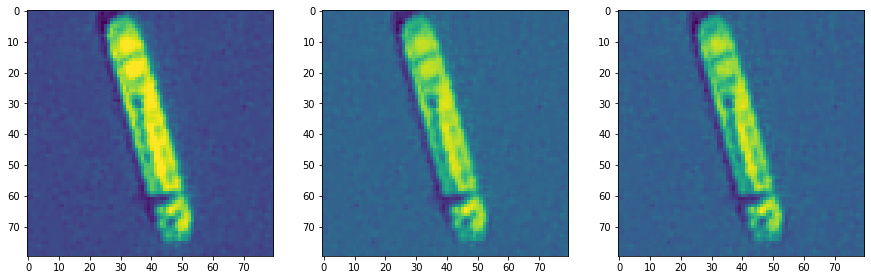

In [6]:
plt.figure( figsize = (15,15))

# show each channel
for i in range(0,3):
    plt.subplot(1, 3, (i+1))
    plt.imshow(Xt[100,:,:,i])

Dsiplaying the RGB image for the first 20 images:

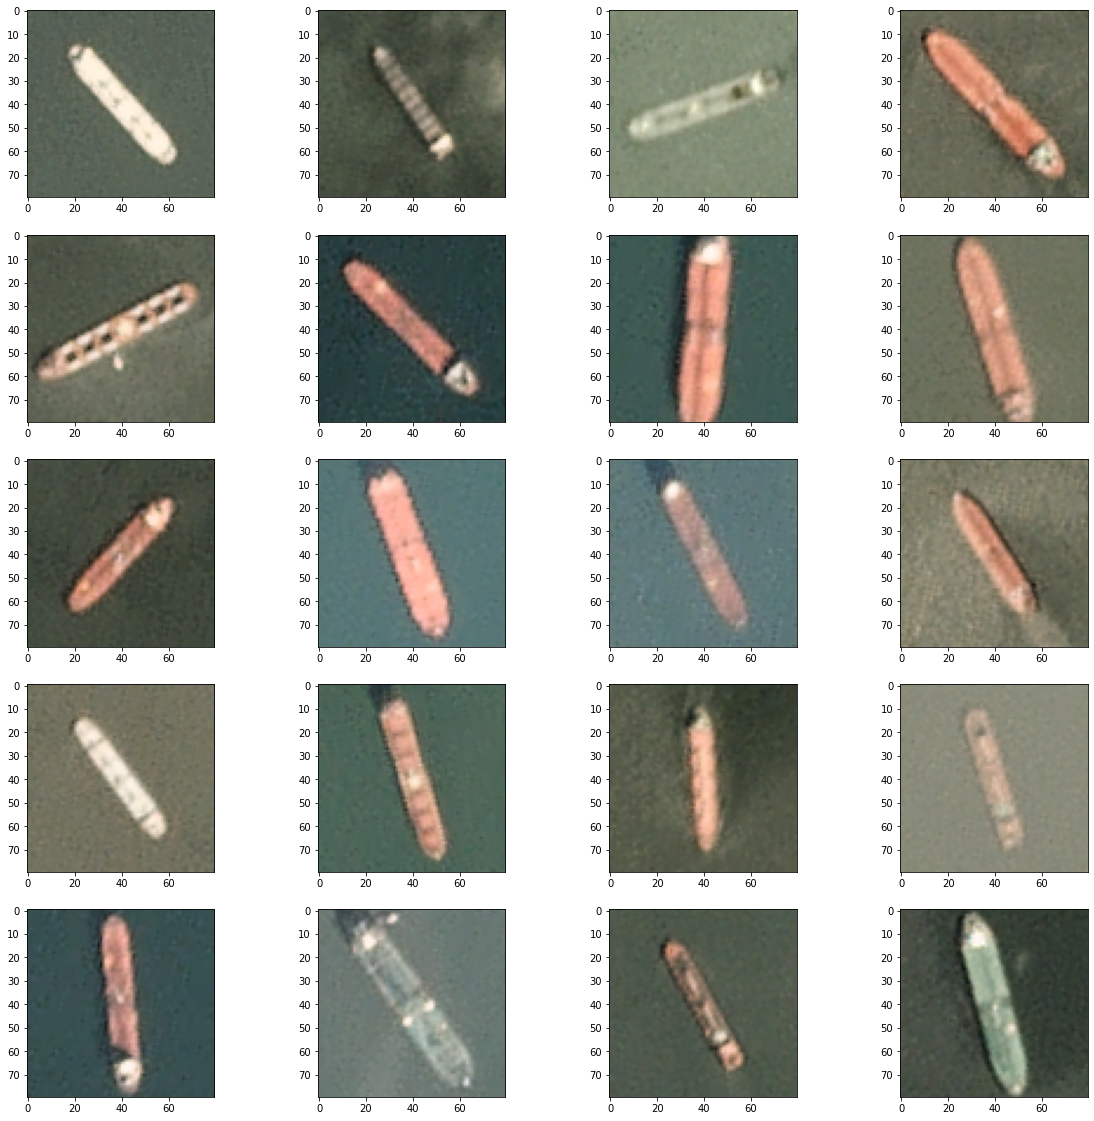

In [7]:
plt.figure( figsize = (20,20))

# show each channel
for i in range(0,20):
    plt.subplot(5, 4, (i+1))
    plt.imshow(Xt[i,:,:,:])



The dataset contains of 1000 images without ships (labelled with 0) and 3000 images with ships (labelled with 1): 

In [8]:
Presence_Absence=pd.value_counts(pd.Series(labels_data))
Presence_Absence

0    3000
1    1000
dtype: int64

Splitting the dataset into Train, Validation and Test:

In [9]:
# Create train set
data_train, data_test, labels_train, labels_test = train_test_split(
    input_data,
    labels_data,
    test_size=.45, random_state=0, stratify=labels_data)

# Create validation and test sets
data_validation, data_test, labels_validation, labels_test = train_test_split(
data_test, labels_test,test_size=.20, random_state=0)

data_train=data_train.reshape(-1, n_spectrum, weight, height)
data_test=data_test.reshape(-1, n_spectrum, weight, height)
data_validation=data_validation.reshape(-1, n_spectrum, weight, height)

print('Train:',data_train.shape, labels_train.shape)
print('Test:', data_test.shape, labels_test.shape)
print('Validation:', data_validation.shape, labels_validation.shape)

Train: (2200, 3, 80, 80) (2200,)
Test: (360, 3, 80, 80) (360,)
Validation: (1440, 3, 80, 80) (1440,)


Permute the dimensions of each array:

In [10]:
data_t_train=data_train.transpose(0,2,3,1)
data_t_test=data_test.transpose(0,2,3,1)
data_t_validation=data_validation.transpose(0,2,3,1)

Choosing the Number of Components in a PCA for the dataset:

Text(0.5, 1.0, 'PCA')

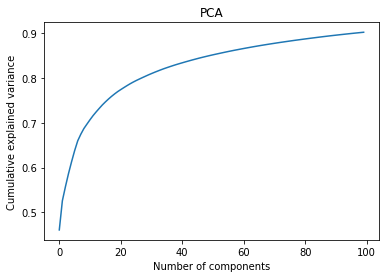

In [11]:
pca = PCA(n_components=100)
values_train=data_train.reshape(-1,(80*80*3))
pca.fit(values_train)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA')



80 components would be enought to retain most of the dataset information:

In [12]:
NCOMPONENTS = 80

pca = PCA(n_components=NCOMPONENTS)


data_pca_train = pca.fit_transform(data_train.reshape(-1,(80*80*3)))
data_pca_val = pca.transform(data_validation.reshape(-1,(80*80*3)))
data_pca_test = pca.transform(data_test.reshape(-1,(80*80*3)))
pca_std = np.std(data_pca_train)


Convert the labels vectors from integers to binary class matrices:

In [13]:
labels_train=to_categorical(labels_train)
labels_test=to_categorical(labels_test)
labels_validation=to_categorical(labels_validation)

In [14]:
print(data_pca_val.shape)
print(labels_validation.shape)

(1440, 80)
(1440, 2)


FCNN model calibration:

In [15]:
from tensorflow.keras.optimizers import RMSprop
model_fcnn = Sequential([
  Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001),input_shape=(80,)),
  Dropout(0.1),
  Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
  Dropout(0.1),
  Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
  Dropout(0.1),
  Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)),
])

model_fcnn.summary()


model_fcnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=RMSprop(),
              metrics=['accuracy'])

model_fcnn.fit(
  data_pca_train, # training data
  labels_train, # training targets
  validation_data=(data_pca_val, labels_validation),
  epochs=100,
  batch_size=200
)

2022-03-08 05:29:39.524789: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-08 05:29:39.693736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                5184      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6

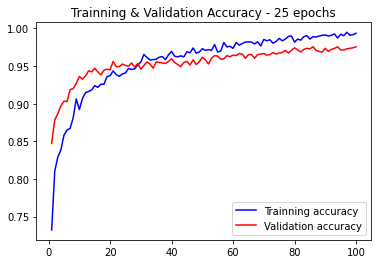

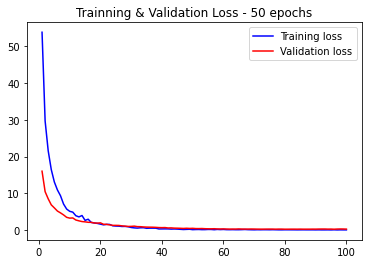

12/12 [==============================] - 0s 2ms/step - loss: 0.1482 - accuracy: 0.9667
Test loss 0.15
Test accuracy 0.97


In [16]:
acc=model_fcnn.history.history['accuracy']
val_acc=model_fcnn.history.history['val_accuracy']
loss=model_fcnn.history.history['loss']
val_loss=model_fcnn.history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'b',label='Trainning accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Trainning & Validation Accuracy - 25 epochs')
plt.legend()
plt.figure()
plt.plot(epochs,loss, 'b', label='Training loss')
plt.plot(epochs,val_loss, 'r', label='Validation loss')
plt.title('Trainning & Validation Loss - 50 epochs')
plt.legend()
plt.show()


test_loss, test_acc =model_fcnn.evaluate(
  data_pca_test,
  labels_test
)

print('Test loss', round(test_loss,2))
print('Test accuracy', round(test_acc,2))

Label prediction for the test dataset:

In [17]:
prediction=model_fcnn.predict(data_pca_test)

Displaying the first 100 images from the test dataset overlaying the test labels as well as the predicted labels with the FCNN model:

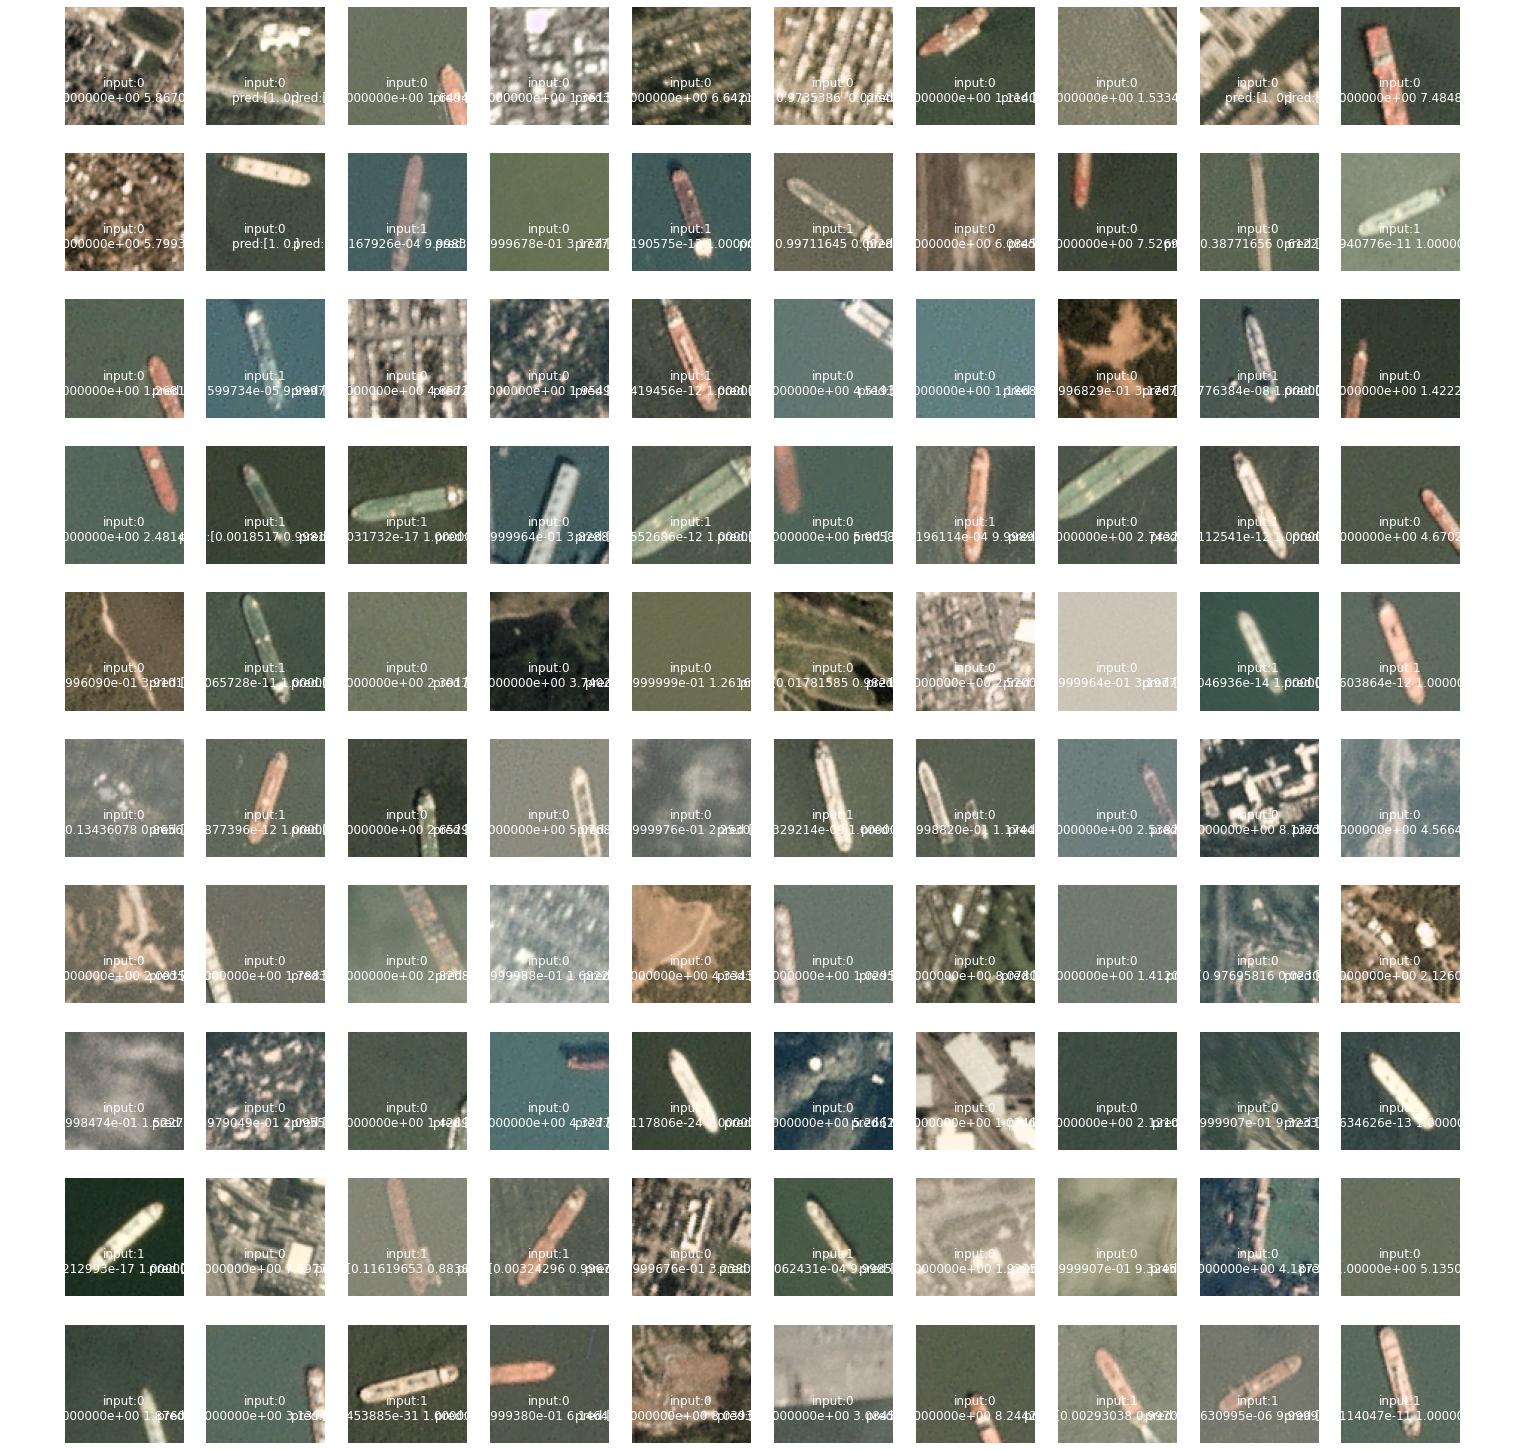

In [18]:
fig=plt.figure(figsize=(25, 25))

random.randint(0,len(data_test))

data_t_test=data_test.transpose(0,2,3,1)
# show each channel
for i in range(0,100):
    fig.add_subplot(10, 10, i+1)
    fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=.2, hspace=.2)
    plt.imshow(data_t_test[i,:,:,:])
    plt.title('input:'+str(labels_test.argmax(axis = 1)[i])+'\npred:'+str(prediction[i]), fontsize=12, y=.15,color='w')
    plt.axis('off')
plt.show()

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Activation

import tensorflow as tf

In [20]:
data_file = open("../input/ships-in-satellite-imagery/shipsnet.json")
shipsnet = pd.read_json(data_file)
shipsnet.head()

data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007

In [21]:
shipsnet["labels"].value_counts()

0    3000
1    1000
Name: labels, dtype: int64

In [22]:
x = np.concatenate(shipsnet["data"].values)
print(f"Min RGB value: {min(x)}.")
print(f"Max RGB value: {max(x)}.")
print(f"NaN values: {np.isnan(x).sum()}.")

Min RGB value: 1.
Max RGB value: 255.
NaN values: 0.


In [23]:
shipsnet["normalised_data"] = shipsnet["data"].apply(lambda x : np.array(x) / 255)

In [24]:
shipsnet["reshaped_data"] = shipsnet["normalised_data"].apply(lambda x : x.reshape([3, 80, 80]).transpose([1, 2, 0]))

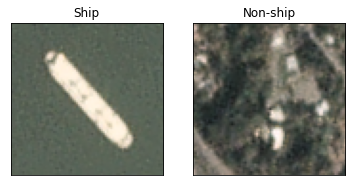

In [25]:
plt.subplot(121)
plt.title("Ship")
plt.xticks([])
plt.yticks([])
plt.imshow(shipsnet["reshaped_data"][0])

plt.subplot(122)
plt.title("Non-ship")
plt.xticks([])
plt.yticks([])
plt.imshow(shipsnet["reshaped_data"][3500])

plt.show()

In [26]:
X = shipsnet["reshaped_data"]
y = shipsnet["labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
X_train = np.array(X_train.tolist()).astype(float)
X_test = np.array(X_test.tolist()).astype(float)
y_train = np.array(y_train.tolist()).astype(float)
y_test = np.array(y_test.tolist()).astype(float)

In [28]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(80, 80, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [29]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [30]:
gen_model = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
94/94 [==============================] - 11s 111ms/step - loss: 0.4250 - accuracy: 0.8533 - val_loss: 0.2203 - val_accuracy: 0.9040
Epoch 2/10
94/94 [==============================] - 10s 107ms/step - loss: 0.2458 - accuracy: 0.8980 - val_loss: 0.1780 - val_accuracy: 0.9280
Epoch 3/10
94/94 [==============================] - 11s 115ms/step - loss: 0.1912 - accuracy: 0.9310 - val_loss: 0.1646 - val_accuracy: 0.9260
Epoch 4/10
94/94 [==============================] - 10s 106ms/step - loss: 0.1414 - accuracy: 0.9460 - val_loss: 0.1347 - val_accuracy: 0.9510
Epoch 5/10
94/94 [==============================] - 10s 105ms/step - loss: 0.1200 - accuracy: 0.9553 - val_loss: 0.1681 - val_accuracy: 0.9320
Epoch 6/10
94/94 [==============================] - 11s 117ms/step - loss: 0.0892 - accuracy: 0.9683 - val_loss: 0.1295 - val_accuracy: 0.9460
Epoch 7/10
94/94 [==============================] - 10s 107ms/step - loss: 0.0673 - accuracy: 0.9793 - val_loss: 0.1110 - val_accuracy: 0.9660

In [31]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions.round()))
print(confusion_matrix(y_test, predictions.round()))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       733
         1.0       0.95      0.97      0.96       267

    accuracy                           0.98      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.98      0.98      0.98      1000

[[719  14]
 [  9 258]]


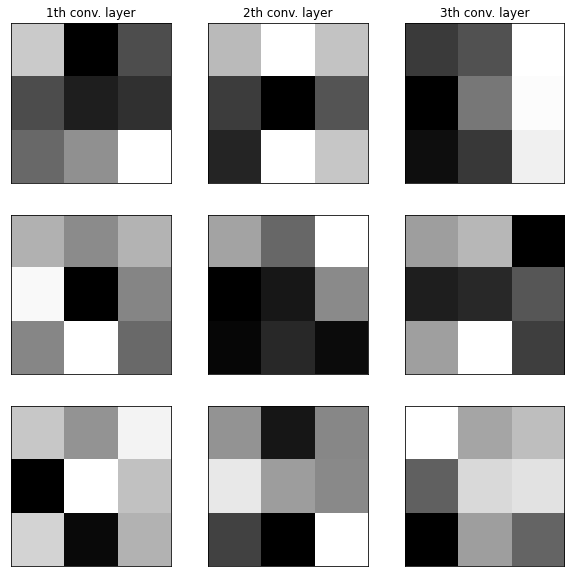

In [32]:
plt.figure(figsize=(10, 10))

for layer in [0, 2, 4]:
    
    filters, biases = model.layers[layer].get_weights()

    for f in range(3):

        plt.subplot(3, 3, 1 + int(layer/2) + 3*f)
        plt.imshow(filters[:, :, 0, f], cmap='gray')
        plt.xticks([])
        plt.yticks([])

        if f == 0:
            plt.title(f"{int(layer/2) + 1}th conv. layer")

plt.show()

In [33]:
ships_test_indexs = np.where(y_test)[0]
non_ships_test_indexs = np.where(y_test==0)[0]

ships_test = X_test[ships_test_indexs]
non_ships_test = X_test[non_ships_test_indexs]

In [34]:
ixs = [0, 2, 4]
outputs = [model.layers[i].output for i in ixs]
new_model = models.Model(inputs=model.inputs, outputs=outputs)

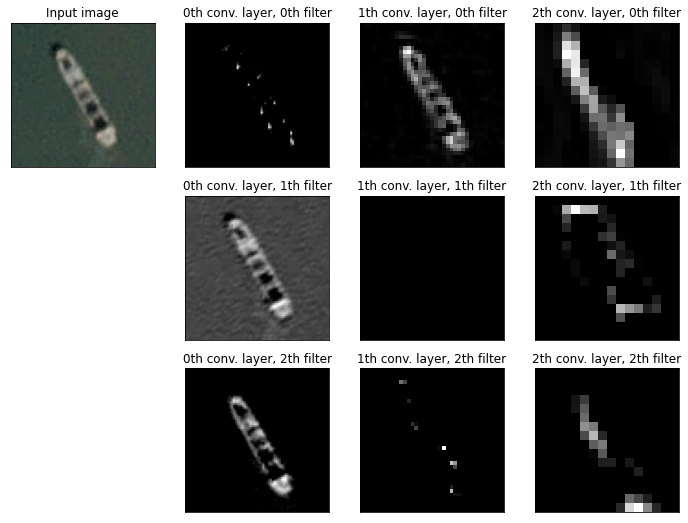

In [35]:
plt.figure(figsize=(12, 9))

for f in range(3):
    
    for layer in range(4):
        
        if layer == 0 and f == 0:
            plt.subplot(3, 4, 1 + layer + 4*f)
            plt.title("Input image")
            plt.imshow(ships_test[0])
            plt.xticks([])
            plt.yticks([])
        elif layer != 0:
            plt.subplot(3, 4, 1 + layer + 4*f)
            plt.title(f"{layer-1}th conv. layer, {f}th filter")
            fmap = new_model.predict(ships_test[[0]])[layer-1]
            plt.imshow(fmap[0, :, :, f], cmap='gray')
            plt.xticks([])
            plt.yticks([])

plt.show()

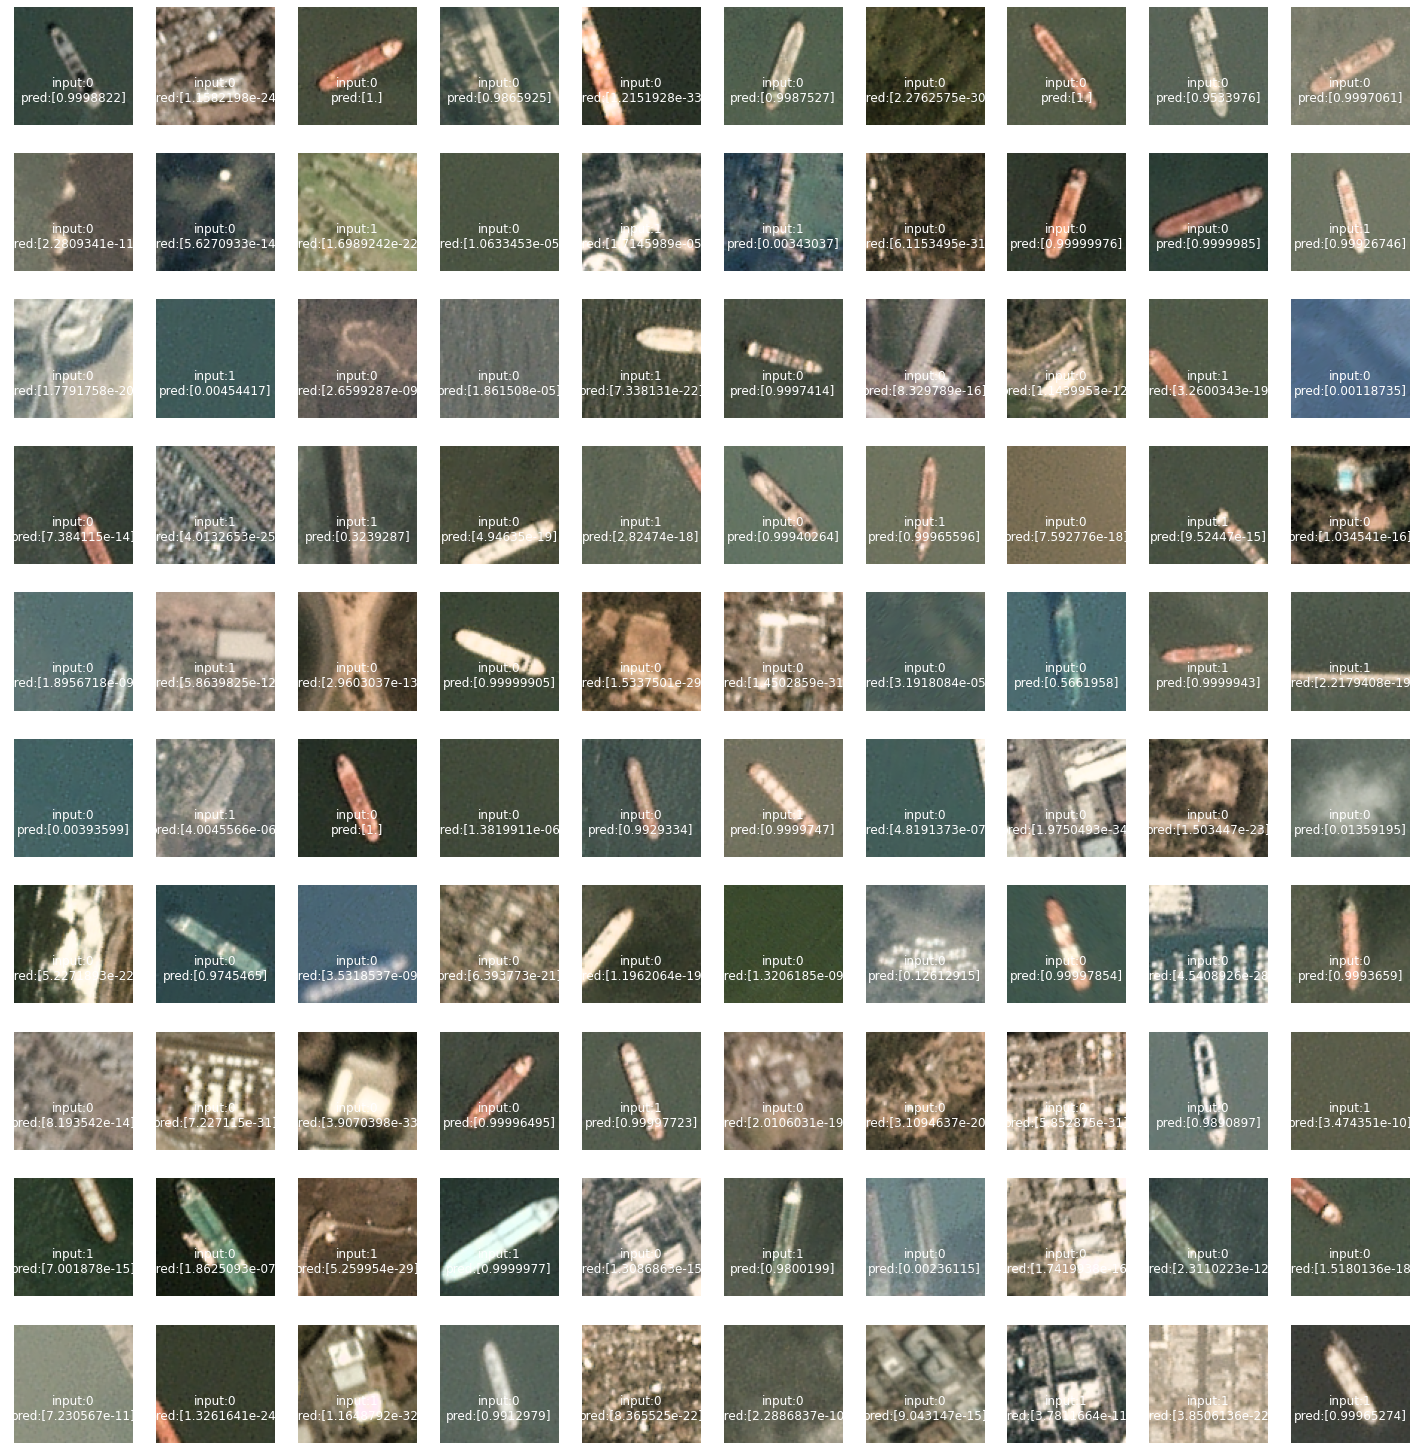

In [36]:
fig=plt.figure(figsize=(25, 25))

random.randint(0,len(X_test))

data_t_test=data_test.transpose(0,2,3,1)
# show each channel
for i in range(0,100):
    fig.add_subplot(10, 10, i+1)
    fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=.2, hspace=.2)
    plt.imshow(X_test[i,:,:,:])
    plt.title('input:'+str(labels_test.argmax(axis = 1)[i])+'\npred:'+str(predictions[i]), fontsize=12, y=.15,color='w')
    plt.axis('off')
plt.show() 

In [37]:
import numpy as np
import json
import matplotlib.pyplot as plt

In [38]:
file = open('../input/ships-in-satellite-imagery/shipsnet.json')
dataset = json.load(file)
file.close()

In [39]:
dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [40]:
data = np.array(dataset['data']).astype('uint8')

In [41]:
data.shape

(4000, 19200)

In [42]:
label_data = np.array(dataset['labels']).astype('uint8')

In [43]:
label_data.shape

(4000,)

In [44]:
# reshape data
channels = 3
width = 80
height = 80

X = data.reshape(-1, 3, width, height).transpose([0,2,3,1])
X.shape

(4000, 80, 80, 3)

(80, 80, 3)


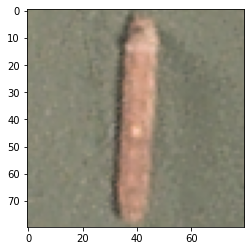

In [45]:
# check sample shape and plot
print(X[800].shape)
sample_pic = X[800]
plt.imshow(X[800])

In [46]:
type(sample_pic)

numpy.ndarray

In [47]:
from skimage import color
sample_pic_gr = color.rgb2gray(sample_pic)
sample_pic_gr.shape

(80, 80)

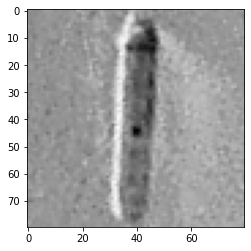

In [48]:
plt.imshow(sample_pic_gr)
plt.set_cmap('Greys')

In [49]:
# converting all images to greyscale. Output is a list

X_grey = [ color.rgb2gray(i) for i in X]
X_grey = np.array(X_grey)
X_grey.shape

(4000, 80, 80)

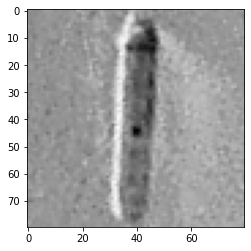

In [50]:
plt.imshow(X_grey[800])

In [51]:
label_data[800]

1

In [52]:
# Training data is a 3D matrix. Convert to a 2D matrix. 
X_grey = X_grey.reshape(len(X_grey), -1)
X_grey.shape

(4000, 6400)

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_grey, label_data, test_size=0.2, random_state=42)

In [54]:
# SVM Classifier 

# SVC with rbf kernel. Standard scaler

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


svc_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(gamma='scale'))
])

svc_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [55]:
svc_clf.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])>

In [56]:
from sklearn.metrics import classification_report,accuracy_score
y_pred = svc_clf.predict(X_test)

print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.94875


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       591
           1       0.93      0.87      0.90       209

    accuracy                           0.95       800
   macro avg       0.94      0.92      0.93       800
weighted avg       0.95      0.95      0.95       800



In [57]:
from sklearn.svm import LinearSVC

linearsvc_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(loss='hinge'))
])

linearsvc_clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(loss='hinge'))])

In [58]:
y_pred = linearsvc_clf.predict(X_test)

print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.83125


              precision    recall  f1-score   support

           0       0.94      0.83      0.88       591
           1       0.63      0.84      0.72       209

    accuracy                           0.83       800
   macro avg       0.78      0.83      0.80       800
weighted avg       0.86      0.83      0.84       800



In [59]:
from sklearn.linear_model import SGDClassifier

sgd_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd_clf', SGDClassifier())
])

sgd_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('sgd_clf', SGDClassifier())])

In [60]:
y_pred = sgd_clf.predict(X_test)

print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.84875


              precision    recall  f1-score   support

           0       0.89      0.91      0.90       591
           1       0.73      0.67      0.70       209

    accuracy                           0.85       800
   macro avg       0.81      0.79      0.80       800
weighted avg       0.85      0.85      0.85       800



In [61]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop, SGD
# Import the backend
from keras import backend as K

In [62]:
label_data

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)